In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoo_fin import stock_info as y_fin
import json
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta
import math
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [1]:
def drawLine2P(x,y,xlims):
    """Returns a vector crossing point x and point y.

        Parameters:
            x: First point
            y: Second point
            xlims = Range of x space to draw the line through, list
                e.g., [x_min, x_max]

        Returns:
            [x, y]"""
            
    xrange = np.arange(xlims[0],xlims[1],1)
    A = np.vstack([x, np.ones(len(x))]).T
    k, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return [xrange, k*xrange + b]

In [122]:
def PlotTimeSeries(ticker, years_ago=5, verbose_mode=False):#, months_ago=0):
    """Returns monthly Price Chart and iterated Support/Resistance Lines for input stock ticker.

        Parameters:
            ticker: string
                    Stock ticker to be charted, must conform to Yahoo Finance format
                    e.g., RY.TO, QAN.AX
            years_ago: integer, default 5
                    Number of years of stock price history to chart
            verbose_mode: bool, default False
                    Calls out Breach points
                    Good for additional analysis or testing
    """    
    
    # There are two Yahoo Modules we can use to pull our data (closeHist)
    # We'll pull from one and if we get an error will use the alternate
    try:
        closeHist = pd.DataFrame(yf.download(ticker,
                                             period='max', 
                                             progress=False)['Close']).rename({'Close':'Price'}, axis=1)
        #closeHist = pd.DataFrame(yf.Ticker(ticker).history(period='max')['Close']).rename({'Close':'Price'}, axis=1)
        closeHist.index = closeHist.index.to_pydatetime()
        closeHist.index.name = 'Date'
    except json.JSONDecodeError:
        closeHist = pd.DataFrame(y_fin.get_data(ticker)['close']).rename({'close':'Price'}, axis=1)
        closeHist.index = closeHist.index.to_pydatetime()
        closeHist.index.name = 'Date'
    # Trim our data to years_ago
    closeHist = closeHist[closeHist.index > dt.datetime.now() + relativedelta(years=-years_ago)]
    closeHist.reset_index(inplace=True)
    #Calculate monthly avg. Price
    closeHist['Month'] = closeHist.Date.apply(lambda x: dt.date(x.year, x.month, 1))
    closeHist = closeHist.groupby('Month').last().rename({'Price':'Price(Monthly avg.)'}, axis=1)
    closeHist['x_index'] = pd.Series(range(len(closeHist.index)), closeHist.index)

    # Find Peaks and Troughs (Local Maximums and Minimums)
    MinSeries = closeHist['Price(Monthly avg.)'][(closeHist['Price(Monthly avg.)'].shift(1) > closeHist['Price(Monthly avg.)']) &  
                                                 (closeHist['Price(Monthly avg.)'].shift(-1) > closeHist['Price(Monthly avg.)'])]
    MaxSeries = closeHist['Price(Monthly avg.)'][(closeHist['Price(Monthly avg.)'].shift(1) < closeHist['Price(Monthly avg.)']) &  
                                                 (closeHist['Price(Monthly avg.)'].shift(-1) < closeHist['Price(Monthly avg.)'])]
    
    
    MinSeries = pd.concat([MinSeries, 
                           closeHist['Price(Monthly avg.)'][(closeHist.index <= MaxSeries.index[0])&
                                                            (closeHist['Price(Monthly avg.)'] < MaxSeries.iloc[0])].head(1)]).sort_index()

    
    #BothSeries = pd.concat([MinSeries, MaxSeries]).sort_index()
    #MaxMaxSeries = BothSeries[(BothSeries.shift(1) < BothSeries) & (BothSeries.shift(-1) < BothSeries)]
    #MinMinSeries = BothSeries[(BothSeries.shift(1) > BothSeries) & (BothSeries.shift(-1) > BothSeries)]
    
    

    #3PTL Buy Line
    X = list()
    Y = list()
    x_1_date = MaxSeries.idxmax()
    x_1 = closeHist[closeHist.index==x_1_date].x_index.iloc[0]
    X.append(x_1)
    Y.append(MaxSeries.max())
    try:
        x_2_date = MaxSeries[MaxSeries.index > x_1_date].idxmax()
        x_2 = closeHist[closeHist.index==x_2_date].x_index.iloc[0]
        X.append(x_2)
        Y.append(MaxSeries[MaxSeries.index > x_1_date].max())
    except ValueError:
        pass
    #3PTL Sell Line
    X2 = list()
    Y2 = list()
    x2_1_date = MinSeries.idxmin()
    x2_1 = closeHist[closeHist.index==x2_1_date].x_index.iloc[0]
    X2.append(x2_1)
    Y2.append(MinSeries.min())
    try:
        x2_2_date = MinSeries[MinSeries.index > x2_1_date].idxmin()
        x2_2 = closeHist[closeHist.index==x2_2_date].x_index.iloc[0]
        X2.append(x2_2)
        Y2.append(MinSeries[MinSeries.index > x2_1_date].min())
    except ValueError:
        pass

    print('Current Price for', ticker, 'is', str(round(closeHist['Price(Monthly avg.)'].iloc[-1], 2)))

    sellLine_list = list()
    buyLine_list = list()

    #Calculate and plot Sell line:
    if len(X2) < 2:
    # IF WE CANNOT BUILD A SELL LINE USING MAX, START WITH FIRST TWO TROUGHS
        X2 = list(closeHist.loc[MinSeries.index]['x_index'].iloc[:2])
        Y2 = list(closeHist.loc[MinSeries.index]['Price(Monthly avg.)'].iloc[:2])
        ThreePtS = drawLine2P(x=X2,y=Y2,xlims=[closeHist['x_index'].values.min(),
                                               closeHist['x_index'].values.max()+1])
        sellLine_list.append(ThreePtS[1])
    else: 
        ThreePtS = drawLine2P(x=X2,y=Y2,xlims=[closeHist['x_index'].values.min(),
                                  closeHist['x_index'].values.max()+1])
        sellLine_list.append(ThreePtS[1])

    #Calculate and plot Buy line:
    if len(X) < 2:
        pass
    else: 
        ThreePtB = drawLine2P(x=X,y=Y,xlims=[closeHist['x_index'].values.min(),
                                  closeHist['x_index'].values.max()+1])
        buyLine_list.append(ThreePtB[1])


    Buy_Breach = max(closeHist[closeHist.x_index.isin(X2)].index)
    if verbose_mode:
        n = 1 #TESTING
    while Buy_Breach:
        # FIRST BUY ITERATION
        latestHist = closeHist.loc[Buy_Breach:]
        subSell = latestHist.index[latestHist['Price(Monthly avg.)'] < pd.Series(ThreePtS[1], closeHist.index).loc[Buy_Breach:]]
        if len(subSell) > 0:
            Sell_Breach = subSell[0]        
            preBreach = MaxSeries[MaxSeries.index < Sell_Breach].index
            postBreach = MaxSeries[MaxSeries.index > Sell_Breach].index
            if verbose_mode:
                print("{} Sell Breach at {}, this is Breach #{}".format(ticker, Sell_Breach, n)) #TESTING
                n+=1
            if len(postBreach) > 0:
                pt_1 = closeHist.loc[closeHist.loc[preBreach]['Price(Monthly avg.)'].idxmax()]
                pt_2 = closeHist.loc[postBreach[0]]
                Y2 = [pt_1['Price(Monthly avg.)'], pt_2['Price(Monthly avg.)']]
                X2 = [pt_1['x_index'], pt_2['x_index']]
                ThreePtB = drawLine2P(x=X2,y=Y2,xlims=[closeHist['x_index'].values.min(),
                                                       closeHist['x_index'].values.max()+1])
    #                plt.plot(closeHist.index, ThreePtB[1],
    #                         c='g', linestyle='dashed', 
    #                         alpha=buyAlpha)
                buyLine_list.append(ThreePtB[1])
            else:
                Sell_Breach = None
                break        
        else:
            Sell_Breach = None
            break
        while Sell_Breach:
            # FIRST SELL ITERATION
            latestHist = closeHist.loc[Sell_Breach:]
            superBuy = latestHist.index[latestHist['Price(Monthly avg.)'] > pd.Series(ThreePtB[1], closeHist.index).loc[Sell_Breach:]]
            if len(superBuy) > 0:
                Buy_Breach = superBuy[0]
                preBreach = MinSeries[MinSeries.index < Buy_Breach].index
                postBreach = MinSeries[MinSeries.index > Buy_Breach].index
                if verbose_mode:
                    print("{} Buy Breach at {}, this is Breach #{}".format(ticker, Buy_Breach, n)) #TESTING
                    n+=1
                if len(postBreach) > 0:
                    pt_1 = closeHist.loc[closeHist.loc[preBreach]['Price(Monthly avg.)'].idxmin()]
                    pt_2 = closeHist.loc[postBreach[0]]
                    Y2 = [pt_1['Price(Monthly avg.)'], pt_2['Price(Monthly avg.)']]
                    X2 = [pt_1['x_index'], pt_2['x_index']]
                    ThreePtS = drawLine2P(x=X2,y=Y2,xlims=[closeHist['x_index'].values.min(),
                                                           closeHist['x_index'].values.max()+1])
    #                    plt.plot(closeHist.index, ThreePtS[1],
    #                             c='r', linestyle='dashed', 
    #                             alpha=sellAlpha)
                    sellLine_list.append(ThreePtS[1])

                    break
                else:
                    Buy_Breach = None
                    break
            else:
                Buy_Breach = None
                break
    #sellLine_alpha = np.linspace(0.1, 1, len(sellLine_list))
    #buyLine_alpha = np.linspace(0.1, 1, len(buyLine_list))
    sellLine_alpha = np.flipud(np.linspace(0.55, 0.1, len(sellLine_list)+1)[:-1])
    buyLine_alpha = np.flipud(np.linspace(0.55, 0.1, len(buyLine_list)+1)[:-1])



    if len(sellLine_list) > 0:
        sellPrice = round(sellLine_list[-1][-1], 2)
        if sellPrice < 0:
            sellPrice = round(0.00, 2)            
        print('Sell Price for', ticker, 'is', sellPrice)
    if len(buyLine_list) > 0:
        buyPrice = round(buyLine_list[-1][-1], 2)
        if buyPrice < 0:
            buyPrice = round(0.00, 2)
        print('Buy Price for', ticker, 'is', buyPrice)

    plt.figure(figsize=[20,9])
    with plt.style.context('fivethirtyeight'):
        plt.plot(closeHist['Price(Monthly avg.)'], zorder=0)
        
        if verbose_mode:
            for i in np.arange(len(sellLine_list)):
                plt.plot(closeHist.index, sellLine_list[i],
                         c='r', linestyle='dashed', 
                         alpha=sellLine_alpha[i])

            for i in np.arange(len(buyLine_list)):
                plt.plot(closeHist.index, buyLine_list[i],
                         c='g', linestyle='dashed', 
                         alpha=buyLine_alpha[i])

        if len(sellLine_list) > 0:
            plt.plot(closeHist.index, sellLine_list[-1],
                     c='r',
                     alpha=1)
        
        if len(buyLine_list) > 0:
            plt.plot(closeHist.index, buyLine_list[-1],
                     c='g', 
                     alpha=1)  

        plt.scatter(MinSeries.index, 
                    MinSeries,
                    c='r', s=50, zorder=10)
        plt.scatter(MaxSeries.index, 
                    MaxSeries,
                    c='g', s=50, zorder=10)
    #    plt.scatter(MaxMaxSeries.index, 
    #                MaxMaxSeries,
    #                c='y', s=100, zorder=5)
    #    plt.scatter(MinMinSeries.index, 
    #                MinMinSeries,
    #                c='y', s=100, zorder=5)
    
    plt.title("Buy and Sell Lines for "+ ticker, {'fontsize':20})
    plt.autoscale()
    num = closeHist['Price(Monthly avg.)'].min()
    Y_lim_min = math.floor(num / 10 ** math.floor(math.log10(num))) * 10 ** math.floor(math.log10(num))
    num = closeHist['Price(Monthly avg.)'].max()
    Y_lim_max = math.ceil(num / 10 ** math.floor(math.log10(num))) * 10 ** math.floor(math.log10(num))
    plt.ylim(0, Y_lim_max)#,Y_lim_max)
    plt.show()

CSU.TO
Current Price for CSU.TO is 1733.08
CSU.TO Sell Breach at 2017-04-01, this is Breach #1
CSU.TO Buy Breach at 2018-05-01, this is Breach #2
CSU.TO Sell Breach at 2018-07-01, this is Breach #3
CSU.TO Buy Breach at 2019-01-01, this is Breach #4
CSU.TO Sell Breach at 2019-01-01, this is Breach #5
CSU.TO Buy Breach at 2019-06-01, this is Breach #6
CSU.TO Sell Breach at 2019-12-01, this is Breach #7
CSU.TO Buy Breach at 2020-05-01, this is Breach #8
CSU.TO Sell Breach at 2020-06-01, this is Breach #9
CSU.TO Buy Breach at 2020-07-01, this is Breach #10
Sell Price for CSU.TO is 1519.55
Buy Price for CSU.TO is 1680.57


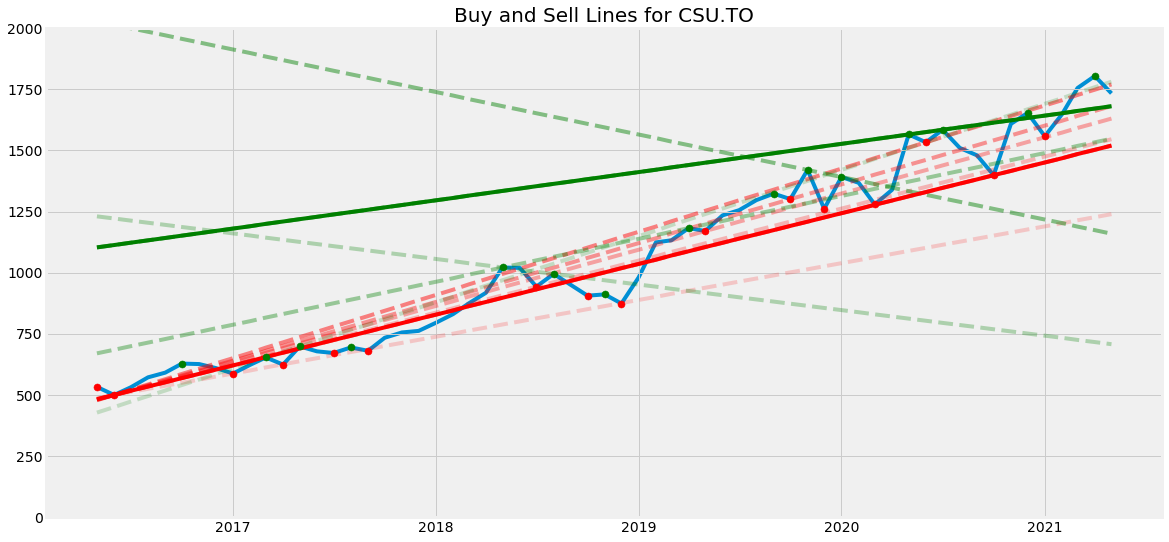

In [126]:
Chart3PTL("""
CSU.TO""", verbose_mode=True)